In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import re
import string
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
pd.set_option('display.max_colwidth', None)

## EDA

In [3]:
#loading the datasets
train_set = pd.read_csv('../raw_data/train.csv')
validation_set = pd.read_csv('../raw_data/validation.csv')
test_set = pd.read_csv('../raw_data/test.csv')

In [4]:
# droppping useless columns
train_data = train_set.drop(['id', 'orig_id'], axis=1)[:800]
val_data = validation_set.drop(['id', 'orig_id'], axis=1)[:200]
test_data = test_set.drop(['id', 'orig_id'], axis=1)[:100]

In [5]:
train_data.shape

(800, 2)

In [6]:
train_data[6:8]

article  \
6  BAGHDAD, Iraq (CNN) -- The women are too afraid and ashamed to show their faces or have their real names used. They have been driven to sell their bodies to put food on the table for their children -- for as little as $8 a day. Suha, 37, is a mother of three. She says her husband thinks she is cleaning houses when she leaves home. "People shouldn't criticize women, or talk badly about them," says 37-year-old Suha as she adjusts the light colored scarf she wears these days to avoid extremists who insist women cover themselves. "They all say we have lost our way, but they never ask why we had to take this path." A mother of three, she wears light makeup, a gold pendant of Iraq around her neck, and an unexpected air of elegance about her. "I don't have money to take my kid to the doctor. I have to do anything that I can to preserve my child, because I am a mother," she says, explaining why she prostitutes herself. Anger and frustration rise in her voice as she speaks. "No matter what else I may be, no matter how off the path I may be, I am a mother!"  Watch a woman describe turning to prostitution to "save my child" » . Her clasped hands clench and unclench nervously. Suha's husband thinks that she is cleaning houses when she goes away. So does Karima's family. "At the start I was cleaning homes, but I wasn't making much. No matter how hard I worked it just wasn't enough," she says. Karima, clad in all black, adds, "My husband died of lung cancer nine months ago and left me with nothing." She has five children, ages 8 to 17. Her eldest son could work, but she's too afraid for his life to let him go into the streets, preferring to sacrifice herself than risk her child. She was solicited the first time when she was cleaning an office. "They took advantage of me," she says softly. "At first I rejected it, but then I realized I have to do it." Both Suha and Karima have clients that call them a couple times a week. Other women resort to trips to the market to find potential clients. Or they flag down vehicles. Prostitution is a choice more and more Iraqi women are making just to survive. "It's increasing," Suha says. "I found this 'thing' through my friend, and I have another friend in the same predicament as mine. Because of the circumstance, she is forced to do such things." Violence, increased cost of living, and lack of any sort of government aid leave women like these with few other options, according to humanitarian workers. "At this point there is a population of women who have to sell their bodies in order to keep their children alive," says Yanar Mohammed, head and founder of the Organization for Women's Freedom in Iraq. "It's a taboo that no one is speaking about." She adds, "There is a huge population of women who were the victims of war who had to sell their bodies, their souls and they lost it all. It crushes us to see them, but we have to work on it and that's why we started our team of women activists." Her team pounds the streets of Baghdad looking for these victims often too humiliated to come forward. "Most of the women that we find at hospitals [who] have tried to commit suicide" have been involved in prostitution, said Basma Rahim, a member of Mohammed's team. The team's aim is to compile information on specific cases and present it to Iraq's political parties -- to have them, as Mohammed puts it, "come tell us what [they] are ... going to do about this." Rahim tells the heartbreaking story of one woman they found who lives in a room with three of her children: "She has sex while her three children are in the room, but she makes them stand in separate corners." According to Rahim and Mohammed, most of the women they encounter say they are driven to prostitution by a desperate desire for survival in the dangerously violent and unforgiving circumstances in Iraq. "They took this path but they are not pleased," Rahim says. Karima says when she sees her children with food on the table, she is able to convi

In [7]:
print(f"train_data.shape: {train_data.shape}")

train_data.shape: (800, 2)


In [8]:
train_data.isna().sum()

article       0
highlights    0
dtype: int64

In [9]:
#val_data.isna().sum()

In [10]:
test_data.isna().sum()

article       0
highlights    0
dtype: int64

### Dealing with duplicates

In [11]:
train_data.duplicated(subset=['article', 'highlights']).sum()

31

In [12]:
val_data.duplicated(subset=['article', 'highlights']).sum()

0

In [13]:
test_data.duplicated(subset=['article', 'highlights']).sum()

0

In [14]:
def del_duplicates(dataset, columns_to_compare):
    '''
    Function that deletes duplicated lines comapres according to indicated columns
    '''
    return dataset.drop_duplicates(subset=columns_to_compare)

    

In [15]:
cols = ['article', 'highlights']

train = del_duplicates(train_data, columns_to_compare=cols)
train.shape

(769, 2)

In [16]:
val = del_duplicates(val_data, columns_to_compare=cols)
val.shape

(200, 2)

In [17]:
test = del_duplicates(test_data, columns_to_compare=cols)
test.shape

(100, 2)

### Potential threshhold for news extraction

 For API/scrapping part can be useful to define what we consider as an article

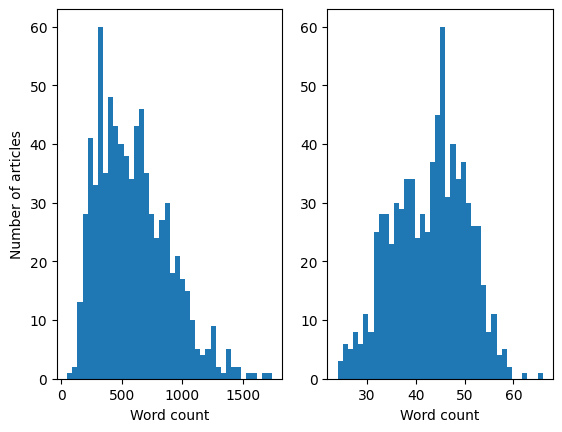

In [18]:
# word count
article_wc = []
summary_wc = []

# populate the lists with sentence lengths
for i in train.article:
      article_wc.append(len(i.split()))

for i in train.highlights:
      summary_wc.append(len(i.split()))

length_df = pd.DataFrame({'text':article_wc, 'summary':summary_wc})

plt.subplot(1, 2, 1)
plt.hist(length_df.text, bins=40)
plt.xlabel("Word count")
plt.ylabel("Number of articles")


plt.subplot(1, 2, 2)
plt.hist(length_df.summary, bins=40)
plt.xlabel("Word count")


plt.show()

## Cleaning the data

In [47]:
def preprocessing(sentence: string, remove_stopwords=True) -> string: 
    
    '''
    Preprocessing text: lower case, 
                        deleting punctuation, 
                        replacing contructions with equivalent,
                        deleting stop words,
                        removing special characters
    '''

    # Lowercase
    sentence = sentence.lower()
   
    # Remove return characters, url and html tags
    code_list = ['\n', '\S*(http|https)\S*', '\<a href', '&amp;', '<br />']
    for code in code_list:
        sentence = re.sub(code, ' ',sentence, flags=re.MULTILINE)
    
    # expand the shortened words (can't => can not)
    # after they will be deleted in stopwords
    expanded = []   
    for word in sentence.split():
        expanded.append(contractions.fix(word, slang=False))
        
    expanded_sentence = ' '.join(expanded)
    
    # remove any parenthisis with text inside
    sentence = re.sub(r'\([^)]*\)', '', expanded_sentence)
    
    # Removing punctuation, url and html tags
    for punctuation in string.punctuation + '[\'\"]':
        sentence = sentence.replace(punctuation, ' ')
        
    # remove special characters 
    sentence = re.sub("[^a-zA-Z]", ' ', sentence)
    sentence = re.sub("\s+", ' ', sentence)

    # Removing whitespaces
    sentence = sentence.strip()
                
    if remove_stopwords:
        stop_words = set(stopwords.words('english')) ## defining stopwords    
        sentence_list = [w for w in sentence.split() if not w in stop_words]
        sentence = (' '.join(sentence_list)).strip()
        
    return sentence

**testing all on a subset of data**

In [52]:
def cleaning(dataset: pd.Series, remove_stopwords=True) -> list:
    '''
    This function creates a cleaned version of each dataset.
    Calls the preprocessing function.
    '''
    rmv_stop = remove_stopwords
    clean = []
    for text in dataset:
        clean.append(preprocessing(text, remove_stopwords=rmv_stop))
    return clean

In [53]:
%%time

X_train = cleaning(train.article)
y_train = cleaning(train.highlights, remove_stopwords=False)

CPU times: user 1.79 s, sys: 65.5 ms, total: 1.85 s
Wall time: 1.95 s


In [54]:
y_train[:3]

['harry potter star daniel radcliffe gets    m fortune as he turns    monday   young actor says he has no plans to fritter his cash away   radcliffe s earnings from first five potter films have been held in trust fund  ',
 'mentally ill inmates in miami are housed on the  forgotten floor  judge steven leifman says most are there as a result of  avoidable felonies  while cnn tours facility  patient shouts   i am the son of the president  leifman says the system is unjust and he is fighting for change  ',
 'new   i thought i was going to die   driver says   man says pickup truck was folded in half  he just has cut on face   driver   i probably had a         foot free fall  minnesota bridge collapsed during rush hour wednesday  ']

In [51]:
print(train.highlights[:3].apply(preprocessing, remove_stopwords=False))

0                                                                     harry potter star daniel radcliffe gets    m fortune as he turns    monday   young actor says he has no plans to fritter his cash away   radcliffe s earnings from first five potter films have been held in trust fund  
1    mentally ill inmates in miami are housed on the  forgotten floor  judge steven leifman says most are there as a result of  avoidable felonies  while cnn tours facility  patient shouts   i am the son of the president  leifman says the system is unjust and he is fighting for change  
2                                                              new   i thought i was going to die   driver says   man says pickup truck was folded in half  he just has cut on face   driver   i probably had a         foot free fall  minnesota bridge collapsed during rush hour wednesday  
Name: highlights, dtype: object


/var/folders/xt/8t3t9kmn787_rthnt36ggbyc0000gn/T/ipykernel_11374/688880914.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(train.highlights[:3].apply(preprocessing, remove_stopwords=False))


In [33]:
print(train.highlights[:3].apply(lambda x: preprocessing(x, remove_stopwords=False)))

0                                                                     harry potter star daniel radcliffe gets    m fortune as he turns    monday   young actor says he has no plans to fritter his cash away   radcliffe s earnings from first five potter films have been held in trust fund
1    mentally ill inmates in miami are housed on the  forgotten floor  judge steven leifman says most are there as a result of  avoidable felonies  while cnn tours facility  patient shouts   i am the son of the president  leifman says the system is unjust and he is fighting for change
2                                                              new   i thought i was going to die   driver says   man says pickup truck was folded in half  he just has cut on face   driver   i probably had a         foot free fall  minnesota bridge collapsed during rush hour wednesday
Name: highlights, dtype: object


/var/folders/xt/8t3t9kmn787_rthnt36ggbyc0000gn/T/ipykernel_11374/3346925275.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(train.highlights[:3].apply(lambda x: preprocessing(x, remove_stopwords=False)))


In [22]:
type(X_train)

list

In [22]:
print(f'Clean article : {X_train[0]}')
print('\n')
print(f'Clean summary : {y_train[0]}')

Clean article : london england harry potter star daniel radcliffe gains access reported million fortune turns monday insists money cast spell daniel radcliffe harry potter harry potter order phoenix disappointment gossip columnists around world young actor says plans fritter cash away fast cars drink celebrity parties plan one people soon turn suddenly buy massive sports car collection something similar told australian interviewer earlier month think particularly extravagant things like buying things cost pounds books cds dvds radcliffe able gamble casino buy drink pub see horror film hostel part ii currently six places number one movie uk box office chart details mark landmark birthday wraps agent publicist comment plans definitely sort party said interview hopefully none reading radcliffe earnings first five potter films held trust fund able touch despite growing fame riches actor says keeping feet firmly ground people always looking say kid star goes rails told reporters last month 

In [23]:
%%time

X_val = cleaning(val.article)
y_val = cleaning(val.highlights, remove_stopwords=False)

CPU times: user 446 ms, sys: 15.7 ms, total: 462 ms
Wall time: 464 ms


In [24]:
%%time

X_test = cleaning(test.highlights, remove_stopwords=False)
y_test = cleaning(test.article)

CPU times: user 221 ms, sys: 10.2 ms, total: 232 ms
Wall time: 233 ms


### !!! Only for target data => adding start and stop to sequence


In [25]:
def adding_decoder_tokens(data: pd.Series) -> pd.Series:
    '''
    Adding special tokens for the decoder only to target string
    '''
    
    return pd.Series(data).apply(lambda x : '_START_ '+ x + ' _END_')

y_train = adding_decoder_tokens(y_train)
y_val = adding_decoder_tokens(y_val)

In [26]:
y_train[0]

'_START_ harry potter star daniel radcliffe gets fortune turns monday young actor says plans fritter cash away radcliffe earnings first five potter films held trust fund _END_'

## Tokenization

We need to provide different tokenizer vocabularies for article and summary

In [27]:
# initialize the max len for article and summary
max_len_text = 700
max_len_summary= 50

### Article tokenization

In [28]:
# learning the dictionnary from train articles
X_tokenizer = Tokenizer()
X_tokenizer.fit_on_texts(list(X_train))

# Transforms each article in articles to a sequence of integers.
X_train_tok = X_tokenizer.texts_to_sequences(X_train) 
X_val_tok = X_tokenizer.texts_to_sequences(X_val)

In [29]:
print('Tokenized article looks like this : ')
print(X_train_tok[0])

Tokenized article looks like this : 
[226, 334, 1145, 4571, 608, 1733, 4572, 3940, 1175, 103, 88, 4573, 2458, 73, 5429, 257, 1927, 4976, 1733, 4572, 1145, 4571, 1145, 4571, 538, 3294, 4224, 11147, 14881, 115, 33, 282, 2159, 25, 490, 14882, 1680, 160, 1211, 888, 3475, 2359, 1611, 409, 2, 3, 589, 644, 4225, 982, 1212, 1612, 157, 2459, 171, 1039, 11, 1176, 11148, 162, 117, 38, 1007, 14883, 203, 23, 3476, 203, 799, 1520, 2073, 11149, 9049, 4572, 255, 11150, 4574, 982, 3475, 11151, 53, 3941, 1213, 11152, 101, 1803, 1476, 124, 1040, 185, 2, 950, 843, 1316, 152, 6720, 1248, 861, 5976, 1997, 7752, 1389, 9050, 914, 490, 2568, 1568, 111, 1, 583, 3694, 1430, 2460, 4572, 7753, 18, 121, 4571, 2960, 228, 951, 1431, 255, 2360, 596, 830, 4977, 7754, 2159, 25, 1928, 706, 7755, 417, 3, 283, 500, 46, 2461, 608, 844, 14884, 11, 501, 19, 117, 491, 340, 89, 65, 4, 952, 889, 6721, 590, 11153, 1145, 4571, 538, 3294, 1613, 1317, 1477, 2569, 14885, 479, 19, 6, 2960, 26, 1064, 284, 1734, 4571, 889, 76, 1249, 457

In [30]:
# post-padding with zeros up to maximum length
X_train_pad = pad_sequences(X_train_tok, dtype='float32', maxlen=max_len_text, padding='post') 
X_val_pad = pad_sequences(X_val_tok, dtype='float32', maxlen=max_len_text, padding='post')

X_vocab = len(X_tokenizer.word_index) + 1

In [31]:
print(f'The size of train articles vocabulary is {X_vocab}')

The size of train articles vocabulary is 24267


### Summary tokenization

In [32]:
# learning the dictionnary from train summaries
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

# Transforms each summary in summaries to a sequence of integers.
y_train_tok = y_tokenizer.texts_to_sequences(y_train) 
y_val_tok = y_tokenizer.texts_to_sequences(y_val) 

In [33]:
# post-padding with zeros up to maximum length
y_train_pad = pad_sequences(y_train_tok, dtype='float32', maxlen=max_len_summary, padding='post')
y_val_pad = pad_sequences(y_val_tok,  dtype='float32', maxlen=max_len_summary, padding='post')

y_vocab = len(y_tokenizer.word_index) + 1

In [34]:
print(f'The size of train summary vocabulary is {y_vocab}')

The size of train summary vocabulary is 6821


# Test with scraper

In [40]:
from dotenv import load_dotenv, find_dotenv
from bs4 import BeautifulSoup
import requests, os
from datetime import datetime
import numpy as np

In [41]:
url_list = ['https://edition.cnn.com/2022/11/17/tech/twitter-employees-ultimatum-deadline/index.html',
'https://edition.cnn.com/2022/11/17/india/modi-india-g20-influence-intl-hnk/index.html',
'https://www.dailymail.co.uk/sport/sportsnews/article-11442203/Qatar-want-alcohol-sales-World-Cup-stadiums-BANNED.html',
'http://edition.cnn.com/2022/11/18/us/five-things-november-18-trnd/index.html',
'https://www.dailymail.co.uk/sport/sportsnews/article-11443573/Man-United-respond-Cristiano-Ronaldo-interview-Piers-Morgan.html',
'https://www.dailymail.co.uk/femail/article-11443077/This-buttons-left-womens-shirts.html',
'https://www.dailymail.co.uk/tvshowbiz/article-11443607/Lorraine-Kelly-shocks-fellow-celebs-expletive-ridden-rant-hilarious-Children-Need-sketch.html']

In [42]:
def get_newskey():
    """
    This function will fetch your NEWS_API from the .env file in the root folder.
    Your .env file should contain a like like: NEWS_API='asdfasdfasdfsadf'
    """
    env_path = find_dotenv()
    file = load_dotenv(env_path)
    return os.getenv('NEWS_API')

In [43]:
def get_news(keyword):
    """
    This function will fetch data from NEWS API based on the keyword entered. 
    The API Key required is taken from the function 'get_newskey'.
    
    Mandatory criteria to be included in the News API request:
    
    - personal api key
    - base url "https://newsapi.org/v2/everything?"
    """
       
    #api_key taken from the get_newskey function
    api_key = get_newskey()
    
    #base url of the API forming the basis for the request
    base_url = "https://newsapi.org/v2/everything?"
    
    #parts of the news articles that the search shall refer to. It is possible to choose between "content", "title", "content"
    search_in = "content"
    
    #criteria for sorting the output of the API
    sort = "popularity" #relevancy, popularity, publishedAt
    
    #web sources to be used
    sources = "cnn" #domains where we would like to search
    
    #date where the search shall start, default via datetime.today: the current date when the API request is made
    date = datetime.today().strftime('%Y-%m-%d')
    
    # line of code to make the actual request based on the variables defined before
    source_url = f'{base_url}q={keyword}&from="{date}"&sortBy={sort}&sources={sources}&searchIn={search_in}&apiKey={api_key}'
    
    news = requests.get(source_url, allow_redirects=True).json()

    return(news)

In [44]:
def get_urls(keyword, limit=10):
    """
    This function will filter the output of the API resulting in a list 
    of the URL's of the articles included in that output from NEWS API 
    based on the keyword entered. 
    """
    
    api_result = get_news(keyword)
    
    list_of_urls = []
    
    for i in range(len(api_result['articles'])):
        
        list_of_urls.append(api_result['articles'][i]['url'])
    
    return list_of_urls[:limit]

In [45]:
def General_scraper(url):
    """
    Input: 'str'
    Output: 'dict'
    
    The function recieve an url, fetch for the html and uses BS4 to extract the paragraph tags. Then it
    counts the number of times that each paragraph is repeated and uses the most repeated (in a news must be text)
    to scrape the news from the website. It returns a dictionary with the title and the text of the news.
    """
    
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    text = soup.find_all('p')

    attrs_list = [' '.join(item.attrs['class']) for item in text if len(item.attrs) > 0]
    values, counts = np.unique(attrs_list, return_counts=True)
    idx = np.where(counts == np.max(counts))
    text_class = str(values[idx]).strip('[]\'')

    text = soup.find_all('p', class_=text_class)
    text = [item.text.strip() for item in text]
    text = ' '.join(text).replace('\xa0', ' ')
    title = soup.title.string.split('|')[0]

    return {'title': title, 'article': text, 'id': 0, 'orig_id': 0}

In [46]:
def get_articles(keyword):
    urls = get_urls(keyword)
    articles = [General_scraper(url) for url in urls]
    df = pd.DataFrame(articles)
    return df    

In [47]:
df = get_articles('business')

In [48]:
df

title  \
0                        Retail sales surged by 1.3% in October as consumers continue to spend despite inflation    
1                                                        Jeff Bezos' top tips for managing the economic downturn    
2                                                    Opinion: I wouldn't bet against Bob Iger's return to Disney    
3                                                                         Oatly plans job cuts as investors sour    
4                         The US monthly budget deficit dropped to $88 billion in October, down 47% for the year    
5                                        Inflation data shows US prices were still uncomfortably high last month    
6                                         Sam Bankman-Fried's $16 billion fortune evaporated in less than a week    
7                               Taylor Swift fans irate at Ticketmaster as huge tour pre-sale demand snarls site    
8  George W. Bush: Former US president to hold a public conversation with Ukrainian President Zelensky next week    
9                                             October jobs report: Employers keep hiring, but unemployment rises    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [51]:
%%time

X_scraper = cleaning(df.article)

CPU times: user 49.4 ms, sys: 1.3 ms, total: 50.7 ms
Wall time: 52.7 ms


In [54]:
len(X_scraper)

10